## Load Data

In [2]:
import pandas as pd
import numpy as np
import os
import CRPS.CRPS as pscore
import copy
from joblib import dump, load
from scipy.stats import nbinom, poisson
from time import sleep
from tqdm import tqdm
import warnings

# create the feature- and actuals-data list
# set the feature and actuals year lists
feature_years = ['2017','2018','2019','2020']
actual_years = ['2018','2019','2020','2021']

actuals_df_list = []
features_df_list = []

# path to the current directory
current_dir = os.getcwd()

for i in range(len(feature_years)):
    # relative paths to the parquet files
    relative_path_features = os.path.join('..', 'data', 'cm_features_to_oct' + feature_years[i] + '.parquet')
    relative_path_actuals = os.path.join('..', 'data', 'cm_actuals_' + actual_years[i] + '.parquet')

    path_features = os.path.join(current_dir, relative_path_features)
    path_actuals = os.path.join(current_dir, relative_path_actuals)

    # append datasets to the lists
    actuals_df_list.append({'year':actual_years[i], 'data':pd.read_parquet(path_actuals, engine='pyarrow')})
    features_df_list.append({'year':feature_years[i], 'data':pd.read_parquet(path_features, engine='pyarrow')})

# concat the feature datasets, so that every data contains the observations starting with january 1990
for i in range(1,len(features_df_list)):
    features_df_list[i]['data'] = pd.concat([features_df_list[i-1]['data'], features_df_list[i]['data']])

country_list = sorted(features_df_list[3]['data'].index.get_level_values('country_id').unique().tolist())

# country group list of all four datasets
country_feature_group_list = []
country_actual_group_list = []
# fill list 
for i in range(len(features_df_list)):
    country_feature_group_list.append(features_df_list[i]['data'].groupby('country_id'))
    country_actual_group_list.append(actuals_df_list[i]['data'].groupby('country_id'))

In [5]:
# check for nan's
for featurelist in features_df_list:
    is_na_series = featurelist['data'].isna().sum()

    for i in range(len(is_na_series)):
        if is_na_series[i] > 0 :
            print(str(is_na_series.index[i]) + ': ' + str(is_na_series[i]))

# wichtig:
analog zur baseline code implementieren, der abfängt, dass auch für jedes Land der letzte Monat vor Jan 2018 verfügbar ist und insgesamt genug Monate vorhanden sind, um mit w_max den train, valid, test Split zu machen

z.b. 246 viel zu wenig Monate für w = 48?!

## Neural Net

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.losses import Loss
import matplotlib.pyplot as plt
import seaborn as sns

# crps loss function 
def crps(y_true, S):
    """
    Computes continuous ranked probability score:

    Parameters
    ----------
    y_true : tf tensor of shape (BATCH_SIZE, 1)
        True values.
    S : tf tensor of shape (BATCH_SIZE, N_SAMPLES)
        Predictive samples.

    Returns
    -------
    tf tensor of shape (BATCH_SIZE,)
        Scores.

    """
    beta=1
    n_samples = S.shape[-1]
    def expected_dist(diff, beta):
        return K.sum(K.pow(K.sqrt(K.square(diff)+K.epsilon()), beta),axis=-1) #axis = -1: last dimension <=> N_SAMPLES
    es_1 = expected_dist(y_true - S, beta)
    es_2 = 0
    for i in range(n_samples):
        es_2 = es_2 + expected_dist(K.expand_dims(S[:,i]) - S, beta)
    return es_1/n_samples - es_2/(2*n_samples**2)

class CRPSLoss(Loss):
    def call(self, y_true, S):
        return crps(y_true, S)

In [22]:
### prediction task for country 223 and actual year 2018
prediction_year = '2018'
dataset_index = actual_years.index(prediction_year)
prediction_country_id = 223

## load datasets
feature_data = country_feature_group_list[dataset_index].get_group(prediction_country_id)
actual_data = country_actual_group_list[dataset_index].get_group(prediction_country_id)

# numbers of months from the feature dataset
month_list_feature_data = feature_data.index.get_level_values('month_id').tolist()
first_month = month_list_feature_data[0]
last_month = month_list_feature_data[-1]



## hyperparameters
w_max = 48 # maximum number of months used for one training run





## split data in train-, validation- and test-dataset
# length of the maximum rolling window and the used "unreal" acutals starting 3 months after the last used month
roll_estim_window_len = w_max + 2 + 12 

# training dataset
last_month_train = last_month - w_max - 12-2-w_max 
data_train = feature_data.loc[(slice(first_month, last_month_train), slice(None)), :] # including "unreal" actuals

# validation dataset
last_month_valid = last_month - w_max
data_validate = feature_data.loc[(slice(last_month_train+1, last_month_valid), slice(None)), :] # including "unreal" actuals

# test dataset
data_test = feature_data.loc[(slice(last_month_valid+1, last_month), slice(None)), :] # no "unreal" actuals and real actuals not included as well


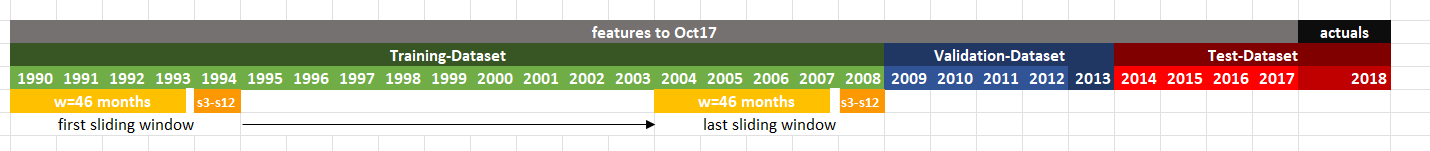

### neural net

In [24]:
from tensorflow.keras import Sequential

model = Sequential()